# Determine DEGs in Deseq2 Data

### 1. Import Required Packages
### 2. Import Deseq2 Data
### 3. Find Total Genes, DEGs, lncRNA DEGs, and Protein-Coding DEGs in Hepatocytes
### 4. K-Means Clustering of all Hepatocyte lncRNA DEGs
### 5. Plot k-means data


## <br> 1. Import Required Packages

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
import warnings

## Define Custom Graph

In [6]:
# Specify the order of doses and times
doses_order = [0.01, 0.03, 0.10, 0.30, 1.00, 3.00, 10.00, 30.00]
dose_colors = ['#ffffff', '#dddede', '#bebfbe', '#9f9f9f', '#7f8080', '#606161', '#404241','#212322']

def plot_gene_of_interest(gene_of_interest, PP_Hep_Merged_Short, PC_Hep_Merged_Short,
                          doses_order, dose_colors):
    
    # Subset data for the current gene in PP_Hep_Merged_Short, PC_Hep_Merged_Short
    subset_pp = PP_Hep_Merged_Short[PP_Hep_Merged_Short['Gene'] == gene_of_interest]
    subset_pc = PC_Hep_Merged_Short[PC_Hep_Merged_Short['Gene'] == gene_of_interest]

    # Calculate y-axis limits
    max_y_pp = subset_pp['log2FoldChange'].max() if not subset_pp.empty else 0
    max_y_pc = subset_pc['log2FoldChange'].max() if not subset_pc.empty else 0
    max_y = max(max_y_pp, max_y_pc, 0) * 1.6

    min_y_pp = subset_pp['log2FoldChange'].min() if not subset_pp.empty else 0
    min_y_pc = subset_pc['log2FoldChange'].min() if not subset_pc.empty else 0
    min_y = min(min_y_pp, min_y_pc, 0) * 1.6

    # Get abundance percentile values for each subset, rounding to 1 decimal place
    abundance_pp = f"{subset_pp['Abundance Percentile'].iloc[0]:.1f}" if not subset_pp.empty else "NA"
    abundance_pc = f"{subset_pc['Abundance Percentile'].iloc[0]:.1f}" if not subset_pc.empty else "NA"

    # Create subplots
    fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(5, 1), sharey=True, gridspec_kw={'wspace': 0.05})

    annotation_fraction = 0.25
    
    # Plot PP_Hep_Merged_Short (Periportal)
    bars2 = ax2.bar(range(len(doses_order)), subset_pp.set_index('Dose').reindex(doses_order)['log2FoldChange'].fillna(0), align='center', alpha=0.7, color=dose_colors, edgecolor='black')
    ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax2.set_xlabel('Dose')
    ax2.set_ylabel(f'{gene_of_interest}\nlog2FoldChange')
    ax2.set_title('RDDR Periportal')
    ax2.set_xticks(range(len(doses_order)))
    ax2.set_xticklabels(doses_order)
    ax2.set_ylim(min_y, max_y)
    ax2.grid(False)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.text(0.05, 0.95, f"{abundance_pp} %", transform=ax2.transAxes, va='top', ha='left')

    for i, bar in enumerate(bars2):
        dose = doses_order[i]
        if dose in subset_pp['Dose'].values:
            if subset_pp[subset_pp['Dose'] == dose]['padj'].iloc[0] <= 0.05:
                if bar.get_height() >= 0:
                    annotation_height = bar.get_height() 
                else:
                    annotation_height = bar.get_height() - annotation_fraction * (max_y - min_y)
                ax2.text(bar.get_x() + bar.get_width() / 2, annotation_height, '*', ha='center', va='bottom')

    # Plot PC_Hep_Merged_Short (Centrilobular)
    bars3 = ax3.bar(range(len(doses_order)), subset_pc.set_index('Dose').reindex(doses_order)['log2FoldChange'].fillna(0), align='center', alpha=0.7, color=dose_colors, edgecolor='black')
    ax3.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax3.set_xlabel('Dose')
    ax3.set_title('RDDR Centrilobular')
    ax3.set_xticks(range(len(doses_order)))
    ax3.set_xticklabels(doses_order)
    ax3.set_ylim(min_y, max_y)
    ax3.grid(False)
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
    ax3.text(0.05, 0.95, f"{abundance_pc} %", transform=ax3.transAxes, va='top', ha='left')

    for i, bar in enumerate(bars3):
        dose = doses_order[i]
        if dose in subset_pc['Dose'].values:
            if subset_pc[subset_pc['Dose'] == dose]['padj'].iloc[0] <= 0.05:
                if bar.get_height() >= 0:
                    annotation_height = bar.get_height() 
                else:
                    annotation_height = bar.get_height() - annotation_fraction * (max_y - min_y)
                ax3.text(bar.get_x() + bar.get_width() / 2, annotation_height, '*', ha='center', va='bottom')

    # Adjust layout
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout()
    
    # Save the plot as PDF with gene_of_interest in the filename
    plt.savefig('./Figures/' + f"{gene_of_interest}_Bar_Graph_Plot.pdf")
    
    plt.show()

In [7]:
Deseq2_Directory = '../03a_TC_DEG_Analysis/Results/03d_MASTER_Deseq2_Concatonated/TC_Deseq2_Master_Wald.txt'

Deseq2_Master_TC = pd.read_csv(Deseq2_Directory, 
                            delimiter = '\t',
                            index_col=0)

Deseq2_Master_TC['Time'] = Deseq2_Master_TC['Time'].astype('category')


Deseq2_Master_TC = Deseq2_Master_TC.sort_values(by='Gene')
Deseq2_Master_TC.reset_index(drop=True, inplace=True)

Deseq2_Master_TC_lncRNA = Deseq2_Master_TC#[Deseq2_Master_TC['Type'] == 'lncRNA']

FileNotFoundError: [Errno 2] No such file or directory: '../03a_TC_DEG_Analysis/Results/03d_MASTER_Deseq2_Concatonated/TC_Deseq2_Master_Wald.txt'

In [ ]:
Percentile_Directory = '../03a_TC_DEG_Analysis/Results/03c_Gene_Counts_and_Percentiles/Max_Count_Gene_Percentile_Per_Celltype.txt'

percentile_df_TC = pd.read_csv(Percentile_Directory, 
                            delimiter = '\t',
                            index_col=0)

## <br> 2. Import RDDR Deseq2 Data

In [8]:
Deseq2_Directory = '../01b_RDDR_DEG_Analysis/Results/03d_MASTER_Deseq2_Concatonated/RDDR_Deseq2_Master_Wald.txt'

Deseq2_Master = pd.read_csv(Deseq2_Directory, 
                            delimiter = '\t',
                            index_col=0)

Deseq2_Master['Dose'] = Deseq2_Master['Dose'].astype('category')


Deseq2_Master = Deseq2_Master.sort_values(by='Gene')
Deseq2_Master.reset_index(drop=True, inplace=True)

Deseq2_Master_lncRNA = Deseq2_Master[Deseq2_Master['Type'] == 'lncRNA']

In [9]:
Percentile_Directory = '../01b_RDDR_DEG_Analysis/Results/03c_Gene_Counts_and_Percentiles/Max_Count_Gene_Percentile_Per_Celltype.txt'

percentile_df = pd.read_csv(Percentile_Directory, 
                            delimiter = '\t',
                            index_col=0)

## 3. Process Dose Response Data

In [10]:
#define Log2FC threshold and padj-value
FC = 1.5
padj = 0.05

In [11]:
Deseq2_PC_Hep = Deseq2_Master_lncRNA[Deseq2_Master_lncRNA['Celltype'] == 'Centrilobular Hepatocytes']
Deseq2_PP_Hep = Deseq2_Master_lncRNA[Deseq2_Master_lncRNA['Celltype'] == 'Periportal Hepatocytes']

percentile_PC_Hep = percentile_df[['Centrilobular Hepatocytes']]
percentile_PP_Hep = percentile_df[['Periportal Hepatocytes']]

percentile_PC_Hep.reset_index(inplace=True)
percentile_PP_Hep.reset_index(inplace=True)

# Perform the merge based on the 'Gene' column from Deseq2_PC_Hep and the index from percentile_df
PC_Hep_Merged = pd.merge(Deseq2_PC_Hep, percentile_PC_Hep, left_on='Gene', right_on='index')
PC_Hep_Merged.drop(columns=['index'], inplace=True)

PP_Hep_Merged = pd.merge(Deseq2_PP_Hep, percentile_PP_Hep, left_on='Gene', right_on='index')
PP_Hep_Merged.drop(columns=['index'], inplace=True)

# Rename the 'X Hepatocytes' column to 'Abundance Percentile'
PC_Hep_Merged.rename(columns={'Centrilobular Hepatocytes': 'Abundance Percentile'}, inplace=True)
PP_Hep_Merged.rename(columns={'Periportal Hepatocytes': 'Abundance Percentile'}, inplace=True)

PC_Hep_Merged_Short = PC_Hep_Merged[['Gene','Celltype','Dose','Fold-Change','log2FoldChange','padj','Abundance Percentile']].drop_duplicates(keep='first')
PP_Hep_Merged_Short = PP_Hep_Merged[['Gene','Celltype','Dose','Fold-Change','log2FoldChange','padj','Abundance Percentile']].drop_duplicates(keep='first')


PC_Hep_DEGs = PC_Hep_Merged_Short[((PC_Hep_Merged_Short['Fold-Change'] >= FC) | 
                             (PC_Hep_Merged_Short['Fold-Change'] <= 1/FC)) &
                             (PC_Hep_Merged_Short['padj'] <= padj)
                            ]

PP_Hep_DEGs = PP_Hep_Merged_Short[((PP_Hep_Merged_Short['Fold-Change'] >= FC) | 
                             (PP_Hep_Merged_Short['Fold-Change'] <= 1/FC)) &
                             (PP_Hep_Merged_Short['padj'] <= padj)
                           ]

#extract only the Abundace Percentiles for histograms
PC_Hep_DEGs_List = PC_Hep_DEGs[['Gene', 'Abundance Percentile']].drop_duplicates(keep='first')
PP_Hep_DEGs_List = PP_Hep_DEGs[['Gene', 'Abundance Percentile']].drop_duplicates(keep='first')


PC_Hep_DEGs_30 = PC_Hep_DEGs[PC_Hep_DEGs['Dose'] == 30.00]
PP_Hep_DEGs_30 = PP_Hep_DEGs[PP_Hep_DEGs['Dose'] == 30.00]


In [12]:
# Find common genes
common_genes = pd.merge(PP_Hep_DEGs_30, PC_Hep_DEGs_30, on='Gene', suffixes=('_PP', '_PC')).drop_duplicates(keep='first')

# Find genes only in PP
only_PP = PP_Hep_DEGs_30[~PP_Hep_DEGs_30['Gene'].isin(PC_Hep_DEGs_30['Gene'])].drop_duplicates(subset=['Gene'], keep='first')

# Find genes only in PC
only_PC = PC_Hep_DEGs_30[~PC_Hep_DEGs_30['Gene'].isin(PP_Hep_DEGs_30['Gene'])].drop_duplicates(subset=['Gene'], keep='first')

# Find examples where one log2FoldChange is positive and the other is negative
positive_negative_pairs = common_genes[((common_genes['log2FoldChange_PP'] > 0) & (common_genes['log2FoldChange_PC'] < 0)) | 
                                       ((common_genes['log2FoldChange_PP'] < 0) & (common_genes['log2FoldChange_PC'] > 0))]

In [13]:
common_genes[['Gene',
              'log2FoldChange_PP','padj_PP','Abundance Percentile_PP',
              'log2FoldChange_PC','padj_PC','Abundance Percentile_PC']].sort_values(by='log2FoldChange_PP')

,Gene,log2FoldChange_PP,padj_PP,Abundance Percentile_PP,log2FoldChange_PC,padj_PC,Abundance Percentile_PC
1057,lnc34452,-10.295216,1.051234e-10,95.658131,-10.634610,4.377611e-12,91.934801
713,lnc23635,-9.012358,2.158633e-29,98.762920,-12.138722,6.677307e-19,95.800173
1343,lnc43881,-8.929508,9.306499e-12,87.678561,-9.351685,9.585298e-13,83.825278
903,lnc2988,-8.448337,4.754751e-07,94.660810,-8.463758,1.681539e-09,92.478794
1666,lnc6894,-7.962119,7.676159e-06,84.702718,-6.834343,1.077219e-05,83.265166
...,...,...,...,...,...,...,...
1704,lnc757,10.275690,2.055652e-20,90.909274,9.492107,7.815202e-16,93.580884
723,lnc2410,10.419649,2.144279e-14,70.197248,10.741433,1.800120e-15,90.071122
1402,lnc46437,10.604104,4.447731e-18,81.652328,10.966780,3.168152e-16,94.388814
1702,lnc752,10.715359,1.068892e-13,82.581146,9.498450,4.547930e-06,89.931094


In [14]:
only_PP[only_PP['Abundance Percentile'] >= 95].sort_values(by='log2FoldChange')

,Gene,Celltype,Dose,Fold-Change,log2FoldChange,padj,Abundance Percentile
20052,lnc15007,Periportal Hepatocytes,30.0,0.233990,-2.095483,1.924533e-02,99.353253
1335,lnc1035,Periportal Hepatocytes,30.0,0.319757,-1.644952,1.574347e-02,96.703806
30071,lnc2065,Periportal Hepatocytes,30.0,0.377576,-1.405162,4.738526e-03,99.147744
11286,lnc12874,Periportal Hepatocytes,30.0,0.394158,-1.343155,4.651995e-05,98.207846
34516,lnc2311,Periportal Hepatocytes,30.0,0.396125,-1.335974,4.754954e-07,95.731670
81066,lnc4995,Periportal Hepatocytes,30.0,0.476888,-1.068279,1.903737e-08,98.922088
97590,lnc9434,Periportal Hepatocytes,30.0,0.532606,-0.908860,2.864610e-02,96.887152
60821,lnc38336,Periportal Hepatocytes,30.0,0.544926,-0.875869,2.272895e-03,99.055064
34264,lnc2296,Periportal Hepatocytes,30.0,0.569116,-0.813206,2.754815e-04,95.590635
81044,lnc4993,Periportal Hepatocytes,30.0,0.602387,-0.731238,3.674762e-02,99.816654


In [15]:
only_PC.sort_values(by='log2FoldChange')

,Gene,Celltype,Dose,Fold-Change,log2FoldChange,padj,Abundance Percentile
66155,lnc6093,Centrilobular Hepatocytes,30.0,0.003351,-8.221090,2.547385e-10,80.812161
35129,lnc29803,Centrilobular Hepatocytes,30.0,0.007014,-7.155577,7.084694e-08,71.027341
56748,lnc46187,Centrilobular Hepatocytes,30.0,0.007771,-7.007614,2.670435e-07,74.216751
35094,lnc29799,Centrilobular Hepatocytes,30.0,0.008395,-6.896205,2.068661e-03,80.868575
60312,lnc48745,Centrilobular Hepatocytes,30.0,0.008565,-6.867300,7.457789e-07,81.044869
...,...,...,...,...,...,...,...
61224,lnc49533,Centrilobular Hepatocytes,30.0,370.294066,8.532528,1.295187e-09,77.829267
61216,lnc49532,Centrilobular Hepatocytes,30.0,435.722744,8.767267,5.125935e-09,76.852094
8579,lnc12662,Centrilobular Hepatocytes,30.0,597.215922,9.222109,1.677290e-11,81.496182
54098,lnc44065,Centrilobular Hepatocytes,30.0,703.265398,9.457925,5.414027e-10,81.551589


In [16]:
positive_negative_pairs[['Gene',
                         'log2FoldChange_PP','padj_PP','Abundance Percentile_PP',
                         'log2FoldChange_PC','padj_PC','Abundance Percentile_PC']]

,Gene,log2FoldChange_PP,padj_PP,Abundance Percentile_PP,log2FoldChange_PC,padj_PC,Abundance Percentile_PC
63,lnc10922,1.508253,0.028962,75.872907,-2.426422,1.292454e-03,93.759192
472,lnc15004,1.649007,0.010875,78.283602,-3.231003,5.908167e-08,82.172144
522,lnc16059,1.294665,0.014523,72.385308,-1.440805,3.549290e-02,68.034372
982,lnc32377,1.852618,0.000921,92.203776,-3.459428,1.001859e-10,94.654766
983,lnc32381,2.679263,0.001241,69.435658,-2.329314,3.356098e-03,71.027341
1856,lnc9692,-0.845930,0.022627,85.923680,1.587284,1.441167e-06,89.271251


In [17]:
PC_Hep_Merged_Short['Gene_Dose'] = PC_Hep_Merged_Short['Gene'] + "_" + PC_Hep_Merged_Short['Dose'].astype(str)
PP_Hep_Merged_Short['Gene_Dose'] = PP_Hep_Merged_Short['Gene'] + "_" + PP_Hep_Merged_Short['Dose'].astype(str)

MASTER_Merge = pd.merge(PP_Hep_Merged_Short, PC_Hep_Merged_Short, on='Gene_Dose', suffixes=('_PP', '_PC')).drop_duplicates(keep='first')


In [18]:
FC_of_interest = 5
FC_of_disinterest = 1.2

PP_of_Interest = MASTER_Merge[
                        (#(MASTER_Merge['Dose_PP'] == 30.0) &
                        ((MASTER_Merge['Fold-Change_PP'] >= FC_of_interest) | (MASTER_Merge['Fold-Change_PP'] <= 1/FC_of_interest)) &
                        (MASTER_Merge['padj_PP'] <= padj)) &

                        ((MASTER_Merge['Fold-Change_PC'] <= FC_of_disinterest) & (MASTER_Merge['Fold-Change_PC'] >= 1/FC_of_disinterest))
                       #(MASTER_Merge['padj_PC'] >= padj))
                      ].sort_values(by='log2FoldChange_PP')

PC_of_Interest = MASTER_Merge[
                        (#(MASTER_Merge['Dose_PC'] == 30.0) &
                        ((MASTER_Merge['Fold-Change_PC'] >= FC_of_interest) | (MASTER_Merge['Fold-Change_PC'] <= 1/FC_of_interest)) &
                        (MASTER_Merge['padj_PC'] <= padj)) &

                        ((MASTER_Merge['Fold-Change_PP'] <= FC_of_disinterest) & (MASTER_Merge['Fold-Change_PP'] >= 1/FC_of_disinterest))
                       #(MASTER_Merge['padj_PC'] >= padj))
                      ].sort_values(by='log2FoldChange_PC')

### Periportal Genes of Interest (Only Significant at 30 in Periportal)

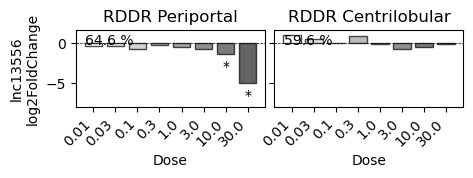

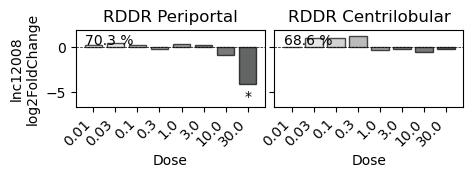

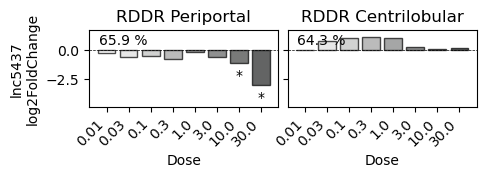

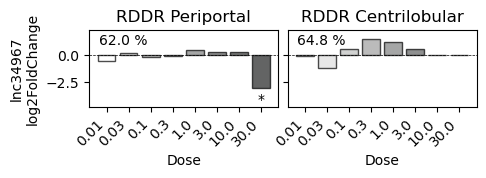

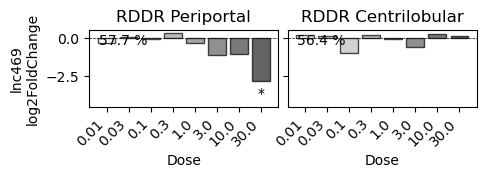

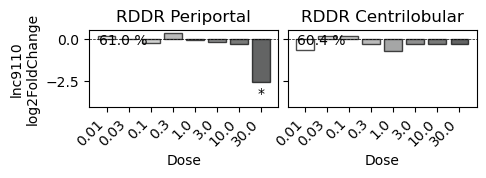

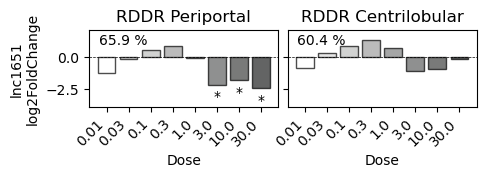

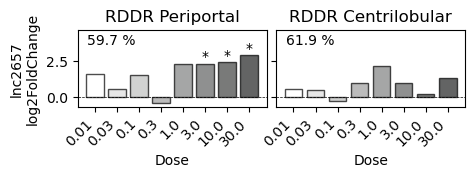

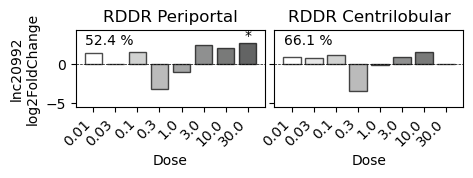

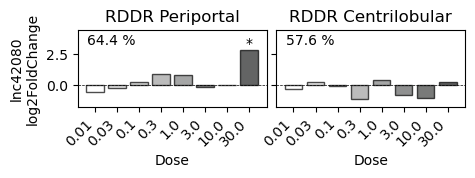

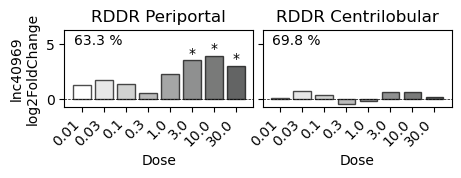

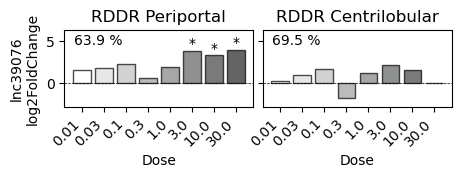

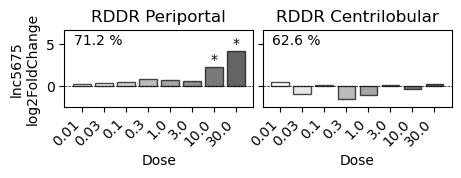

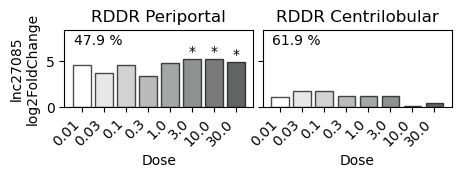

In [19]:
genes_of_interest = PP_of_Interest['Gene_PP']

for gene_of_interest in genes_of_interest:
    plot_gene_of_interest(gene_of_interest, PP_Hep_Merged_Short, PC_Hep_Merged_Short, 
                          doses_order, dose_colors)

### Pericentral Genes of Interest (Only Significant at 30 in Pericentral)

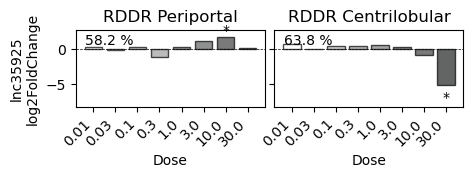

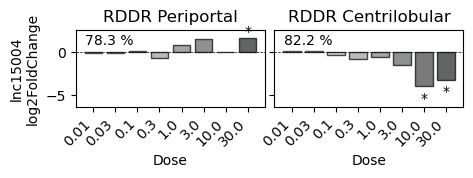

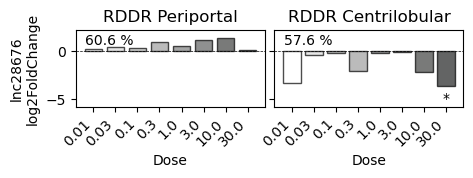

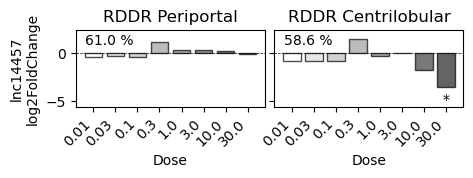

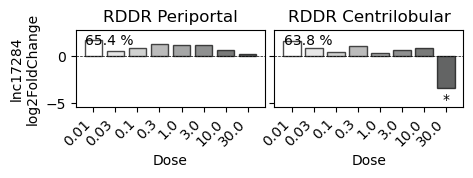

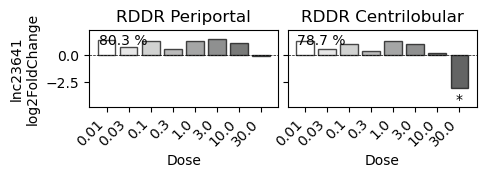

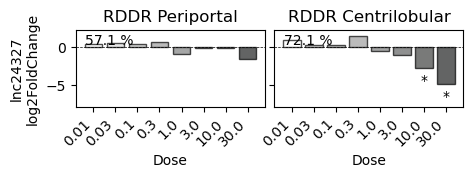

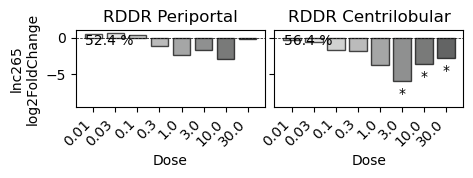

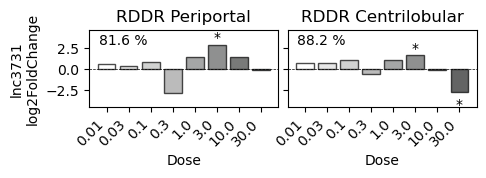

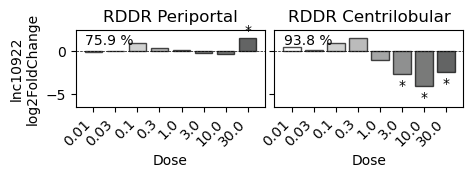

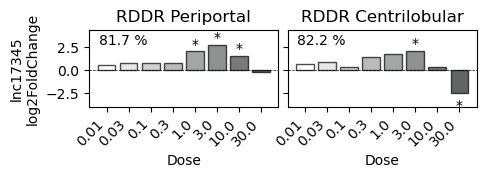

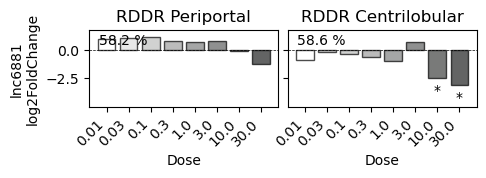

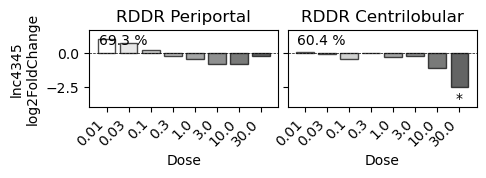

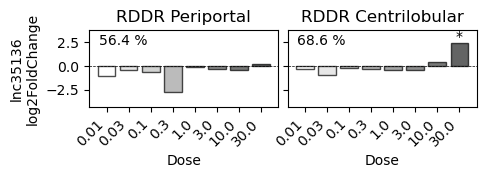

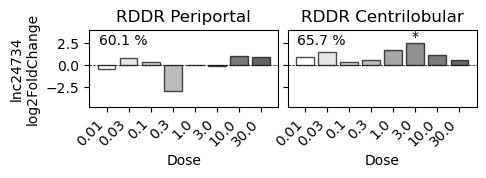

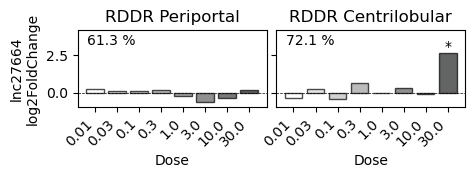

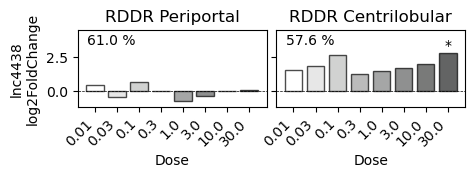

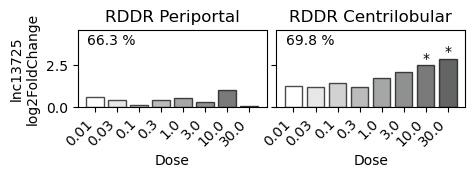

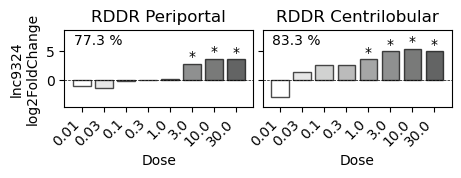

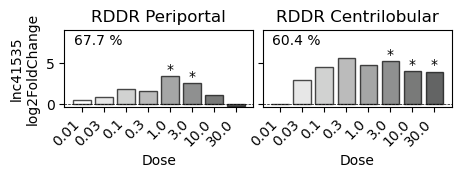

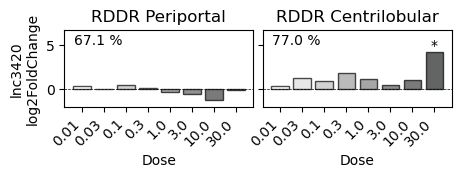

In [20]:
genes_of_interest = PC_of_Interest['Gene_PC']

for gene_of_interest in genes_of_interest:
    plot_gene_of_interest(gene_of_interest, PP_Hep_Merged_Short, PC_Hep_Merged_Short,
                          doses_order, dose_colors)

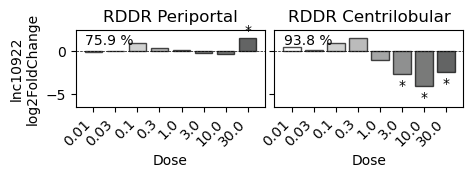

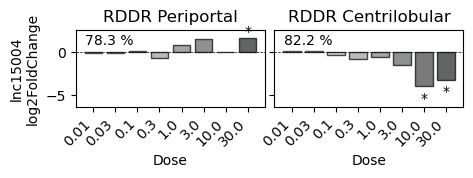

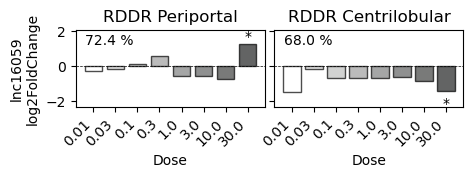

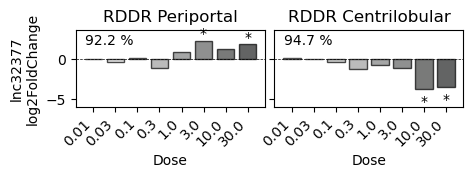

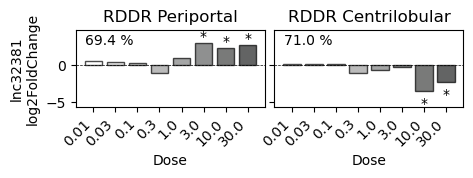

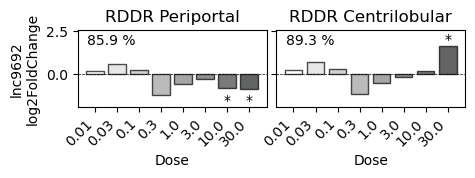

In [21]:
genes_of_interest = positive_negative_pairs['Gene']

for gene_of_interest in genes_of_interest:
    plot_gene_of_interest(gene_of_interest, PP_Hep_Merged_Short, PC_Hep_Merged_Short,
                          doses_order, dose_colors)

### Common Genes of Interest (Top20 Induced and Bottom20 Repressed)

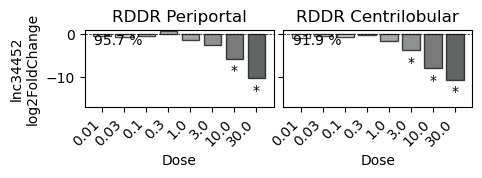

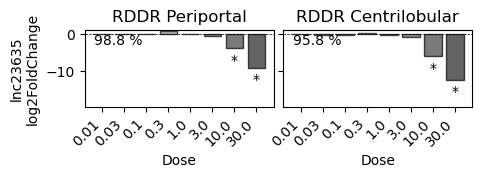

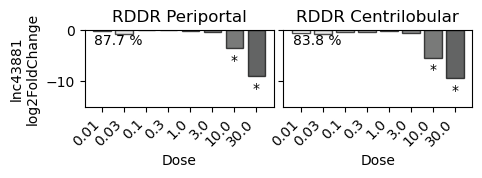

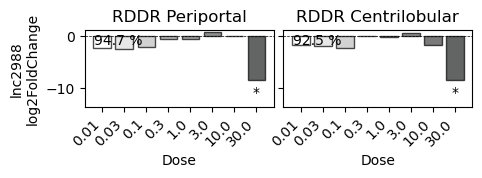

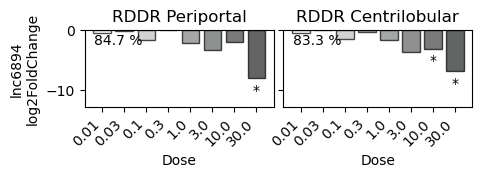

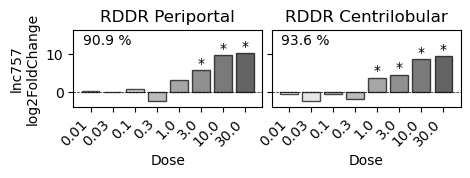

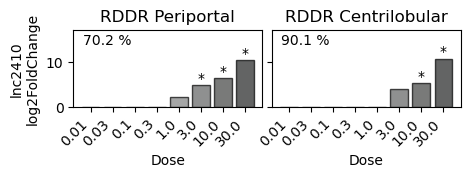

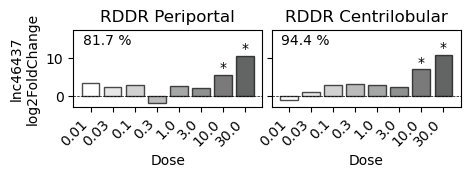

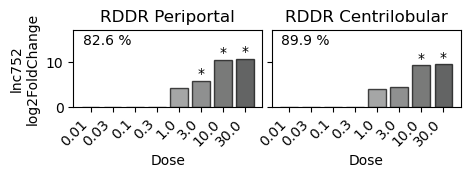

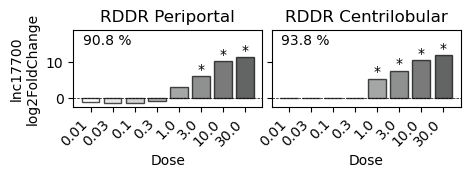

In [22]:
# Sort by log2FoldChange_PP
sorted_genes = common_genes.sort_values(by='log2FoldChange_PP')

# Extract top n and bottom n genes
top_bottom_genes = pd.concat([sorted_genes.head(5), sorted_genes.tail(5)])

genes_of_interest = top_bottom_genes['Gene']

for gene_of_interest in genes_of_interest:
    plot_gene_of_interest(gene_of_interest, PP_Hep_Merged_Short, PC_Hep_Merged_Short,
                          doses_order, dose_colors)

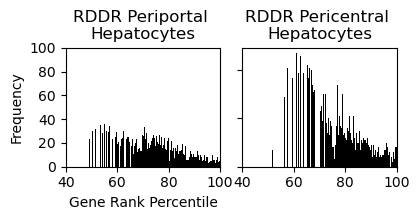

In [23]:
# Determine the common x axis limits
x_min = min(PC_Hep_DEGs_List['Abundance Percentile'].min(),
            PP_Hep_DEGs_List['Abundance Percentile'].min())
x_max = max(PC_Hep_DEGs_List['Abundance Percentile'].max(),
            PP_Hep_DEGs_List['Abundance Percentile'].max())

# Use histograms to determine the y axis limits
hist1, bins1 = np.histogram(PC_Hep_DEGs_List['Abundance Percentile'], bins=500)
y_max = hist1.max()

# Create a figure with 1 row and 3 columns
plt.figure(figsize=(4, 2))


# Plot the second histogram in the second subplot
plt.subplot(1, 2, 1)
plt.hist(PP_Hep_DEGs_List['Abundance Percentile'], bins=300, color='black')
plt.xlabel('Gene Rank Percentile')
plt.title('RDDR Periportal \nHepatocytes')
plt.ylabel('Frequency')
plt.xlim(x_min, x_max)
plt.ylim(0, y_max)
plt.yticks([0, 20,40,60, 80,100])
plt.xticks([40,60,80,100])

# Plot the third histogram in the first subplot
plt.subplot(1, 2, 2)
plt.hist(PC_Hep_DEGs_List['Abundance Percentile'], bins=300, color='black')
plt.title('RDDR Pericentral \nHepatocytes')
plt.xlim(x_min, x_max)
plt.gca().axes.yaxis.set_ticklabels([])  # Hide y-axis labels
plt.xticks([40,60,80,100])


# Adjust spacing between subplots
plt.tight_layout(pad=0)


plt.savefig('./Figures/Histogram_Gene_Rank_Percentile.pdf', format='pdf')
# Display the plots
plt.show()
